In [2]:
"""
UTF-8, Python 3

------------------
Flaring SPI
------------------

Ekaterina Ilin, 2021, MIT License

De-trending Kepler and TESS

- get table of Kepler exoplanet system light curves
- fetch FLC
- get system info from table
- mask transits
- apply custom detrending
- search flares
- save results
"""


import copy
import time

from funcs.notebook import *
from funcs.detrend import estimate_detrended_noise, fit_spline, remove_sines_iteratively, remove_exponential_fringes
from funcs.transitmask import get_full_transit_mask

from altaipony.lcio import from_mast
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median


def custom_detrending(lc, spline_coarseness=30, spline_order=3,
                      savgol1=6., savgol2=3., pad=3):
    """Custom de-trending for TESS and Kepler 
    short cadence light curves, including TESS Cycle 3 20s
    cadence.
    
    Parameters:
    ------------
    lc : FlareLightCurve
        light curve that has at least time, flux and flux_err
    spline_coarseness : float
        time scale in hours for spline points. 
        See fit_spline for details.
    spline_order: int
        Spline order for the coarse spline fit.
        Default is cubic spline.
    savgol1 : float
        Window size for first Savitzky-Golay filter application.
        Unit is hours, defaults to 6 hours.
    savgol2 : float
        Window size for second Savitzky-Golay filter application.
        Unit is hours, defaults to 3 hours.
    pad : 3
        Outliers in Savitzky-Golay filter are padded with this
        number of data points. Defaults to 3.
        
    Return:
    -------
    FlareLightCurve with detrended_flux attribute
    """
    dt = np.mean(np.diff(lc.time))
#     plt.figure(figsize=(16,8))
#     plt.xlim(20,21)
#     plt.plot(lc.time, lc.flux+2500, c="c", label="original light curve")
    t0 = time.clock()
    # fit a spline to the general trends
    lc1, model = fit_spline(lc, spline_order=spline_order,
                            spline_coarseness=spline_coarseness)
    
    # replace for next step
    lc1.flux = lc1.detrended_flux
    t1 = time.clock()
#     plt.plot(lc1.time, model+2500, c="r", label="rough trends")
#     plt.plot(lc1.time, lc1.detrended_flux+500, c="orange", label="rough trends removed")

    # removes strong and fast variability on 5 day to 4.8 hours 
    # simple sines are probably because rotational variability is 
    # either weak and transient or strong and persistent on the timescales
    lc2 = remove_sines_iteratively(lc1)
    t2 = time.clock()
#     plt.plot(lc2time, lc2.detrended_flux-200, label="sines removed")
    
    # choose a 6 hour window
    w = int((np.rint(savgol1 / 24. / dt) // 2) * 2 + 1)

    # use Savitzy-Golay to iron out the rest
    lc3 = lc2.detrend("savgol", window_length=w, pad=pad)
    t3 = time.clock()
    # choose a three hour window
    w = int((np.rint(savgol2 / 24. / dt) // 2) * 2 + 1)

    # use Savitzy-Golay to iron out the rest
    lc4 = lc3.detrend("savgol", window_length=w, pad=pad)
    t4 = time.clock()
#     plt.plot(lc4.time, lc4.detrended_flux-800, c="k", label="SavGol applied")
    
    # find median value
    lc4 = find_iterative_median(lc4)
    t41 = time.clock()
    # replace for next step
    lc4.flux = lc4.detrended_flux
    
    # remove exopential fringes that neither spline, 
    # nor sines, nor SavGol 
    # can remove.
    lc5 = remove_exponential_fringes(lc4)
    t5 = time.clock()
#     plt.plot(lc5.time, lc5.detrended_flux, c="magenta", label="expfunc applied")
    print(t1-t0, t2-t1, t3-t2, t4-t3, t41-t4, t5-t41, t5-t0)
#     plt.xlim(10,40)
#     plt.xlabel("time [days]")
#     plt.ylabel("flux")
#     plt.legend()    
    return lc5


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
sep = "-----------------------------------------"

def mprint(message):
    print(sep)
    print(message)
    print(sep)
    
offset = {"K2":2454833.,
          "Kepler":2454833.,
          "TESS":2457000.,
          'Transiting Exoplanet Survey Satellite (TESS)':2457000.}    

# Composite Table of confirmed exoplanets
path = "20_01_2021_confirmed_uncontroversial_exoplanet_systems.csv"

mprint(f"[UP] Using confirmed and uncontroversial "
      "entries in NASA Composite Table from {path}")

exokepler = pd.read_csv(f"../data/{path}") # composite table

# read in TESS-TOI sample 
path = "../data/2021_01_13_TESS_TOI_CATALOG.csv"

mprint(f"[UP] Using TESS-TOI Table from {path}")

exotess = pd.read_csv(path, skiprows=4)

# rename the relevant columns for transit masking
exotess = exotess.rename(index=str, 
                         columns={'Transit Duration Value':"pl_trandur",
                                  'Orbital Period Value': "pl_orbper", 
                                  'Epoch Value':"pl_tranmidepoch"})


# read in list of LCs to search
es = pd.read_csv("../data/20_01_2021_full_kepler_k2_tess_exoplanet_lcs_some_excluded.csv")

# select only Kepler and TESS, ignore K2 for now
eskeptess = es[(es.mission=="TESS") | (es.mission=="Kepler")]

# # read in searched LCs with and without flares
fla = pd.read_csv("../results/2020_02_flares_vetted.csv")

# # pick only LC that were not yet searched
eskeptess = eskeptess[~eskeptess.ID.isin(fla.ID.unique())]

mprint(f"LC left to search: {eskeptess.shape[0]}")

-----------------------------------------
[UP] Using confirmed and uncontroversial entries in NASA Composite Table from {path}
-----------------------------------------
-----------------------------------------
[UP] Using TESS-TOI Table from ../data/2021_01_13_TESS_TOI_CATALOG.csv
-----------------------------------------
-----------------------------------------
LC left to search: 59
-----------------------------------------


In [65]:
# load info on un-detrended LCs
undet = pd.read_csv("../results/nodetrend.txt", header=None).drop_duplicates(subset=[0,1,2,4])
row = undet.iloc[3]
ID, QCS = row[0],row[1]
row

0                                             WASP-138
1                                                   31
2                                                 TESS
3                                  04_02_2021_11_52_57
4                                                    1
5    Optimal parameters not found: Number of calls ...
Name: 3, dtype: object

In [66]:
#work through a subset first
_eskep = eskeptess[(eskeptess.ID == ID) & (eskeptess.qcs == QCS)]

#track progress
N, n = _eskep.shape[0], 0

# take how long it takes to process
TSTART = time.time()

In [67]:
_eskep

,qcs,mission,ID,TIC,catalog_nasa,catalog_toi,est_obs_time_days
57,31,TESS,WASP-138,35857242,1,1,25


3030    BJD
Name: pl_tranmid_systemref, dtype: object


6% (6230/109893) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
6% (6230/109893) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
6% (1060/18314) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
6% (1060/18314) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony/lcio.py:114: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/TESS/tess2020294194027-s0031-0000000035857242-0198-s/tess2020294194027-s0031-0000000035857242-0198-s_lc.fits' mode='rb' closefd=True>
  c)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony/lcio.py:114: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/TESS/tess2020294194027-s0031-0000000035857242-0198-a_fast/tess2020294

-----------------------------------------
2 light curves available for WASP-138 in TESS.
-----------------------------------------
-----------------------------------------
    Source Pipeline       TIC  Full TOI ID TOI Disposition  \
700            spoc  35857242       400.01              KP   

     TIC Right Ascension  TIC Declination  TMag Value  TMag Uncertainty  \
700             41.63909        -0.463937      11.263             0.018   

     pl_tranmidepoch  Epoch Error  ...  Centroid Offset  TFOP Master  \
700      1413.315221     0.000913  ...            False          5.0   

     TFOP SG1a  TFOP SG1b  TFOP SG2  TFOP SG3 TFOP SG4 TFOP SG5  \
700        5.0        5.0       5.0       5.0      5.0      5.0   

                      Alerted                   Updated  
700  2019-02-08 20:04:48+0000  2019-02-08 20:04:48+0000  

[1 rows x 40 columns]
-----------------------------------------


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.020740000000003533 35.36798399999999 7.591418000000004 7.393334999999993 7.079709000000008 7.143165999999994 64.596352


Found 1 candidate(s) in the (0,49304) gap.
Found 0 candidate(s) in the (49304,97123) gap.


100.0%, [1/1]
-----------------------------------------
Analysis of 1 light curves took 0.0 hours.
-----------------------------------------


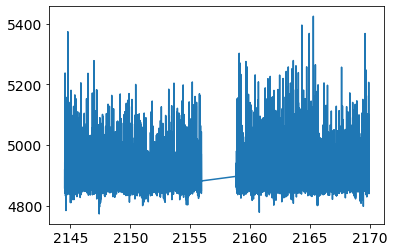

In [68]:
%matplotlib inline
for i, row in _eskep.iterrows():

    # TIC is unique ID for star
    system_tess = exotess[(exotess.TIC == row.TIC)]
    
    # ID is unique, also ignore entries that have no transits
    # because there is nothing to mask (they are still searched for flares)
    system_kepler = exokepler[(exokepler.hostname == row.ID) &
                       (exokepler.discoverymethod == "Transit")]
    
    try:
        if system_kepler.shape[0] > 0:
            system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                                offset[system_kepler.iloc[0].disc_facility])
        system = pd.concat([system_kepler, system_tess],ignore_index=True)
    
    except KeyError:
        system = system_tess
        print(system_kepler.pl_tranmid_systemref)


    # fetch light curve from MAST
    flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short",
                    download_dir="/home/ekaterina/Documents/001_science/lcs")

    # make it a list of LCs even if only one LC is returned
    if type(flc) == FlareLightCurve:

        flc = [flc]

    elif type(flc) == list:

        flc = flc

    # info
    mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")
    
    #info 
    mprint(system)

    # loop over all LCs for the system    
    for i, f in enumerate(flc[:1]):
        
#         plt.xlim(1573,1576)
        # If any planet transiting
#         if system.shape[0] > 0:

#             # mask transits
#             tranmask = get_full_transit_mask(system, f, pad=0)
#             f.flux[tranmask] = np.nan
        
        plt.plot(f.time, f.flux)
        # apply custom detrending
#         try:
        ts = time.clock()
        fd = custom_detrending(f)
        tf = time.clock()


        # define two hour window for rolling std
        w = np.floor(1./12./np.nanmin(np.diff(fd.time)))
        if w%2==0: 
            w+=1

        # use window to estimate the noise in the LC
        df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=2.5)

        # search the residual for flares
        ff = df.find_flares(addtail=True).flares

        # get timestamp for result
        tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())

        # add meta info to flare table
        # if no flares found, add empty row
        if ff.shape[0]==0:
            ff["total_n_valid_data_points"] = df.detrended_flux.shape[0]
            ff["ID"] = row.ID
            ff["qcs"] = row.qcs
            ff["mission"] = row.mission
            ff["tstamp"] = tstamp
            ff["dur_detrend"] = tf - ts
            ff["lc_n"] = i
            ff = ff.append({"total_n_valid_data_points":df.detrended_flux.shape[0],
                            "ID":row.ID,
                            "qcs" : row.qcs,
                            "mission":row.mission,
                            "tstamp":tstamp,
                            "dur_detrend":tf-ts,
                            "lc_n":i},
                             ignore_index=True)

        # otherwise add ID, QCS and mission
        else:
            ff["ID"] = row.ID
            ff["qcs"] = row.qcs
            ff["mission"] = row.mission
            ff["tstamp"] = tstamp
            ff["dur_detrend"] = tf - ts
            ff["lc_n"] = i

    # add results to file
        with open("../results/2021_03_second_try_detrending_flares.csv", "a") as file:
            ff.to_csv(file, index=False, header=False)
#         except Exception as err:
#             mprint(f"{row.ID}, QCS={row.qcs} ({row.mission}) not de-trended!")
#             mprint(err)
#                 with open("../results/nodetrend.txt", "a") as file:
#                     s = f"{row.ID},{row.qcs},{row.mission},{tstamp},{i},{err}\n"
#                     file.write(s)

    # info
    n += 1
    print(f"{n / N * 100.:.1f}%, [{n}/{N}]")

    # breathe
#     time.sleep(10)

TSTOP = time.time()
mprint(f"Analysis of {N} light curves took {(TSTOP - TSTART) / 60. / 60.:.1f} hours.")

In [ ]:
plt.plot(fd.time, fd.detrended_flux)
plt.plot(fd.time, fd.it_med)
plt.plot(fd.time, fd.it_med+3*fd.detrended_flux_err)
plt.plot(flc[0].time, flc[0].flux)
plt.xlim(1588.1,1588.3)

In [ ]:
for j, flare in ff.iloc[110:115].iterrows():
    plt.figure(figsize=(16,5))
    cap=.3
    ts, tf = flare.tstart, flare.tstop
    _ = f[np.where((f.time>=ts-.1/cap) & (f.time<=tf+.1/cap))]
    plt.plot(_.time, _.flux, c="k")

    _ = f[np.where((f.time>=ts-1e-8) & (f.time<=tf+1e-8))]
    plt.scatter(_.time, _.flux, c="r")

#     plt.ylim(278500, 281000)
#     x=1
#     plt.xlim(2036.25+x,2036.75+x)

In [ ]:
%matplotlib inline
LC = f
cad = 2
for i, row in ff.iloc[30:31].iterrows():
    plt.figure(figsize=(17,5))
    ts, tf = row.tstart, row.tstop
    
    # pick

#     if row.mission=="TESS":
#         LC = lc[0]
#         cad=5
#     else:
#         nlc = np.where((ts>tts)[:,0] != (ts>tts)[:,1])[0][0]
#         LC = lc[nlc]
#         cad=1
    _ = LC[np.where((LC.time>=ts-.2/cad) & (LC.time<=tf+.2/cad))]
    plt.plot(_.time, _.flux, c="k")

    _ = LC[np.where((LC.time>=ts-1e-8) & (LC.time<=tf+1e-8))]
#     plt.scatter(_.time, _.flux, c="r")
#     plt.ylim(3200,3900)

In [ ]:
plt.figure(figsize=(17,5))
t = 2037.0445
cad =.5
_ = f[np.where((LC.time>=t-.1/cad) & (LC.time<=t+.1/cad))]
# plt.axvline(t,c="r")
plt.plot(_.time, _.flux)
plt.ylim(278500,280500)

In [ ]:
81/18094/2*60*24

In [ ]:
115/100736*3*60*24

In [ ]:
0.015*24*60

In [ ]:
%matplotlib widget